/srv/jupyter_python3-extras/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in double_scalars
/srv/jupyter_python3-extras/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in double_scalars


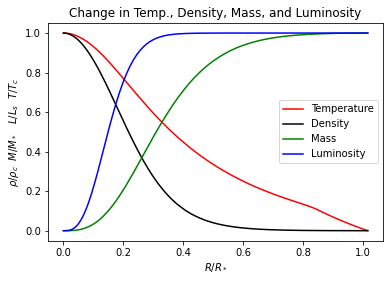

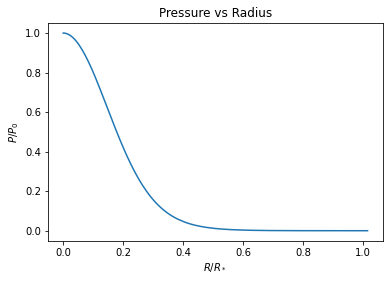

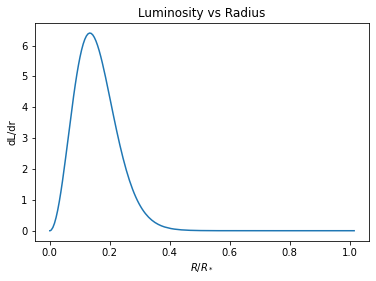

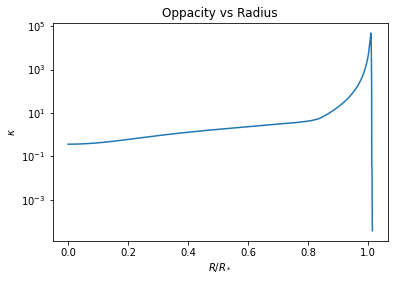

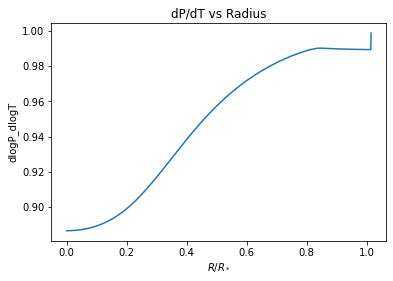

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time, math, sys

######################## Constants for Stars Project ###############################


sigma = 5.670373e-8      
k = 1.381e-23        
c = 299792458           
me = 9.10938291e-31        
mp = 1.67262178e-27       
hbar = 1.05457173e-34      
G = 6.673e-11         
a_rad = (4.0*sigma)/c    
X = 0.73              
Y = 0.25             
Z = 0.02              
mu = (2*X+0.75*Y+0.5*Z)**-1.0            
gamma = 5.0/3.0       
Kappa_es = 0.02*(1 + X) 

#Constants from the example star
M_sun = 1.989e30
R_sun = 6.955e8
L_sun = 3.846e26
M_star = 0.673*M_sun
R_star = 0.865*R_sun
L_star = 5.86e-2*L_sun

class trialStar: #Class to be used to create one star

    def __init__(self,dr,central_density,central_temp,p,Lambda = 0):
        """
        dr = step size to use for numerical integration
        p indicates which pressures we need
           [1,1,1] or [1,0,0] or....
           index 1 for degenerate pressure
           index 2 for ideal gaz pressure
           index 3 for raidative pressure
        """
        self.Lambda = Lambda
        self.individual_pressures = np.zeros(3)
        self.dP_drho_values = np.zeros(3)
        self.dP_dT_values = np.zeros(3)

        self.dr = dr # step size
        self.accuracy = 1.0e14
        self.a = 0
        
    
        self.control = np.array(p)
        
        self.radius = [10.0]
        self.density = [central_density]
        self.temp = [central_temp]
        self.mass = [(4.0/3.0)*np.pi*self.radius[0]**3.0*self.density[0]]
        self.luminosity = [(4.0/3.0)*np.pi*self.radius[0]**3.0*self.density[0]*self.epsilon(self.density[0],self.temp[0])]
        self.opacity = [self.Kappa(self.density[0], self.temp[0])]
        self.tau = [self.Kappa(self.density[0], self.temp[0])*self.density[0]]
        self.pressure = [self.P(self.density[0], self.temp[0])]
        self.dL_dr_values = [0.0]
        
        self.convective = [self.dT_dr_convective(self.mass[0],self.density[0],self.radius[0],self.temp[0],self.luminosity[0])]
        self.radiative = [self.dT_dr_radiative(self.mass[0],self.density[0],self.radius[0],self.temp[0],self.luminosity[0])]
        

        self.derivative_radiative = [self.dT_dr_radiative(self.mass[0],self.density[0],self.radius[0],self.temp[0],self.luminosity[0])]
        self.derivative_convective = [self.dT_dr_convective(self.mass[0],self.density[0],self.radius[0],self.temp[0],self.luminosity[0])]
        
        self.dlogP_dlogT = [(self.temp[-1]/self.pressure[-1])*(self.dP_dT(self.density[-1], self.temp[-1]))]
        
        self.Generate()
        self.a = self.surfaceRad()
        
######################################################################################

    def Generate(self):
        """
        Loops through the Runge-Kutta until opacity condition is met.
        """
        i = 0
        stop_Integration = False # always run through the loop at least once
        while stop_Integration == False:
            rk4_input = np.array([self.density[-1], self.temp[-1], self.mass[-1], self.luminosity[-1], self.tau[-1]],float)

            rk4_output, new_radius = self.AdaptiveRK4(rk4_input, self.radius[-1], self.dr, self.f)
            
            # adding new values
            self.UpdateValues(rk4_output,new_radius)
            # check termination condition
            stop_Integration = self.opacityCheck()
            i += 1
            if self.mass[-1] >= 30.0*M_sun:
                break

    def AdaptiveRK4(self,s,r,h,f):
        """
        Implements adaptive step-sizes for our Runge-Kutta method.
        """
        rho_error = 0.
        increase_h = True
        hmax = 7.0e6 # 0.1% of the suns radius
        i = 0

        while rho_error <= 1.:
  
            xsmall_1, new_radius = self.rk4(s,r,self.dr,f)
            xsmall_2, new_radius2 = self.rk4(xsmall_1,r+self.dr,self.dr,f)
            xbig, notused_radius = self.rk4(s,r,2.*self.dr, f)

            # accuracy for the surface
            accuracy2 = 1.0e-1
            top = 30. * self.dr * self.accuracy
            bottom = np.sqrt(np.sum(np.power((xbig - xsmall_2),2)))

            rho_error = top / bottom
            
            # If temp is getting close to the surface, change hmax to 10km
            if self.temp[-1]/self.temp[0] < 0.008:
                hmax = 5.0e3*(self.temp[0]/8.23e6)
                if self.dr > hmax:
                    self.dr = hmax
                    increase_h = False
                
                top = 30.*self.dr*accuracy2
                bottom = abs(xbig[1]-xsmall_2[1])
                rho_error = top/bottom
                
                i = 1
            
            
            if rho_error > 1. or i == 1:
                if increase_h == True: self.dr *= 2.0 
                if self.dr > hmax:
                    self.dr = hmax
                    increase_h = False
                    i = 1
                    continue
                    
                if rho_error < 2.0 or i == 1:
                 
                    break
                else: 
                  
                    continue
            else:
                self.dr *= 1.0 / 2.0
                
        return xsmall_2, new_radius2

    def rk4(self,s,r,h,f):
        # fourth order runge-kutta
        k1 = h*f(s, r)
        k2 = h*f(s + 0.5*k1, r + 0.5*h)
        k3 = h*f(s + 0.5*k2, r + 0.5*h)
        k4 = h*f(s + k3, r + h)
        return s + (k1 + 2.0*k2 + 2.0*k3 + k4)/6.0, r+h

    def f(self,RK_variables,r):
        # Variables for function calls
        density = RK_variables[0]
        temp = RK_variables[1] 
        mass = RK_variables[2]
        luminosity = RK_variables[3]
        #tau = RK_variables[4]
        radius = r
        #pressure = self.P(density,temp)
        
        frho = self.drho_dr(mass, density, radius, temp, luminosity)
        fT = self.dT_dr(mass, density, radius, temp, luminosity)
        fM = self.dM_dr(density, radius)
        fL = self.dL_dr(density, radius, temp)
        ftau = self.dtau_dr(density, temp)
        return np.array([frho, fT, fM, fL, ftau],float)

    def UpdateValues(self,rk4_output,new_radius):
        self.dL_dr_values.append(self.dL_dr(rk4_output[0],new_radius,rk4_output[1]))
        
        self.density.append(rk4_output[0])
        self.temp.append(rk4_output[1])
        self.mass.append(rk4_output[2])
        self.luminosity.append(rk4_output[3])
        
        if self.temp[-2] - self.temp[-1] < 100.0:
            self.tau.append(rk4_output[4])
        else:
            self.tau.append(0)
            
        self.convective.append(self.dT_dr_convective(self.mass[-1],self.density[-1],self.radius[-1],self.temp[-1],self.luminosity[-1]))
        self.radiative.append(self.dT_dr_radiative(self.mass[-1],self.density[-1],self.radius[-1],self.temp[-1],self.luminosity[-1]))
        
        self.pressure.append(self.P(self.density[-1], self.temp[-1]))
        self.opacity.append(self.Kappa(self.density[-1],self.temp[-1]))
        self.radius.append(new_radius)
        self.dlogP_dlogT.append((self.temp[-1]/self.pressure[-1])*(self.dP_dT(self.density[-1], self.temp[-1])))
        

        self.derivative_radiative.append(abs(self.dT_dr_radiative(self.mass[-2],self.density[-2],self.radius[-2],self.temp[-2],self.luminosity[-2])-self.dT_dr_radiative(self.mass[-1],self.density[-1],self.radius[-1],self.temp[-1],self.luminosity[-1])))
        self.derivative_convective.append(abs(self.dT_dr_convective(self.mass[-2],self.density[-2],self.radius[-2],self.temp[-2],self.luminosity[-2])-self.dT_dr_convective(self.mass[-1],self.density[-1],self.radius[-1],self.temp[-1],self.luminosity[-1])))
    
    ##############################code that checks boundary conditions####################
    def opacityCheck(self):
        #This returns a True or False statement about whether we should continue to integrate outward or not.
        dtau = self.Kappa(self.density[-1], self.temp[-1]) * self.density[-1]**2 / abs(self.drho_dr(self.mass[-1],self.density[-1],self.radius[-1],self.temp[-1],self.luminosity[-1]))
        #print dtau
        
        if dtau < 0.001 or math.isnan(dtau):
            opacityCondition = True
        else:
            opacityCondition = False
        
        if self.radius[-1] > 1.E10: opacityCondition = True #Just in case it wants to integrate forever, we'll cut it off.
        
        return opacityCondition

    #finds the radius that corresponds to tau_surface
    def surfaceRad(self):
        self.a = np.argmin(abs(self.tau[-1]-np.array(self.tau) - (2.0/3.0)))
        if self.tau[self.a] == 0:
            self.a = len(self.tau)-1
        #print self.a
        return self.a


#####Pressure Functions: ###########################################################
    def P(self,density,temp):
        if self.control[0] != 0:
            self.individual_pressures[0] = self.pressure1(density)

        if self.control[1] != 0:
            self.individual_pressures[1] = self.pressure2(density,temp)

        if self.control[2] != 0:
            self.individual_pressures[2] = self.pressure3(temp)

        return np.sum(self.control*self.individual_pressures)

    def dP_drho(self,density,temp):
        if self.control[0] != 0:
            self.dP_drho_values[0] = self.dP_drho_1(density)

        if self.control[1] != 0:
            self.dP_drho_values[1] = self.dP_drho_2(temp)

        return np.sum(self.control*self.dP_drho_values)

    def dP_dT(self,density,temp):
        if self.control[1] != 0:
            self.dP_dT_values[1] = self.dP_dT_2(density)

        if self.control[2] != 0:
            self.dP_dT_values[2] = self.dP_dT_3(temp)

        return np.sum(self.control*self.dP_dT_values)


#####Individual Pressure and Partial Pressure Functions ###########################

    # Degeneracy pressure
    def pressure1(self,density):
        return ((3.0*(np.pi)**2.0)**(2.0/3.0)*(hbar**2.0)*(density/mp)**(5.0/3.0))/(5.0*me)

    # Degeneracy part of differential
    def dP_drho_1(self,density):
        return ((3.0*(np.pi)**2.0)**(2.0/3.0)*(hbar**2.0)*(density/mp)**(2.0/3.0))/(3.0*me*mp)

    # Ideal gas part of differential
    def dP_drho_2(self,temp):
        return (k*temp)/(mu*mp)
        
    # Ideal gas pressure
    def pressure2(self,density,temp):
        return (density*k*temp)/(mu*mp)

    # Radiative pressure
    def pressure3(self,temp):
        return (a_rad*(temp)**4.0)/(3.0)

    # Ideal gas part of differential
    def dP_dT_2(self,density):
        return (density*k)/(mu*mp)

    # Radiative part of differential
    def dP_dT_3(self,temp):
        return (4.0*a_rad*temp**3.0)/(3.0)


#####Functions for the five equations of stellar structure: ########################
    def drho_dr(self, mass, density, radius, temp, luminosity):
        
    
        return -((1+self.Lambda/radius)*(G*mass*density)/(radius**2.0)+self.dP_dT(density,temp)*self.dT_dr(mass,density,radius,temp,luminosity))/self.dP_drho(density,temp)

    # Returns the current rate of change of temperature (this is chosen by which has the minimum derivative)
    def dT_dr(self, mass, density, radius, temp, luminosity):
        return -min(abs(self.dT_dr_radiative(mass, density, radius, temp, luminosity)),abs(self.dT_dr_convective(mass,density,radius,temp,luminosity)))
    

    #######################################################################################
    def dT_dr_radiative(self, mass, density, radius, temp, luminosity):
        T_radiative = (3.0*self.Kappa(density,temp)*density*luminosity)/(16.0*np.pi*4.0*sigma*temp**3.0*radius**2.0)
        return -T_radiative
        
    def dT_dr_convective(self, mass, density, radius, temp, luminosity):
        pressure = self.P(density, temp)
        T_convective = (1.0 - (1.0 / gamma)) * (temp / pressure) * ((G * mass * density) / (radius**2.0)) * (1.0 + self.Lambda/radius)
        return -T_convective
    #######################################################################################
    
    def dM_dr(self, density, radius):
        return 4.0 * np.pi * (radius**2.0) * density

    def dL_dr(self,density,radius,temp):
        return 4.0 * np.pi * (radius**2.0) * density * self.epsilon(density,temp)

    def dtau_dr(self,density,temp):
        return self.Kappa(density,temp) * density


########################################################

    def Kappa(self,density,temp):
        if temp > 1.0e4:
            Kappa = ((1.0 / self.Kappa_Hminus(density, temp)) + (1.0 / max(Kappa_es, self.Kappa_ff(density,temp))))**-1.0
        else:
            Kappa = ((1.0/self.Kappa_Hminus(density,temp)) + (1.0/min(self.Kappa_ff(density,temp), Kappa_es)))**-1.0
        return Kappa

    def Kappa_ff(self,density,temp):
        return (1.0e24) * (1.0+X) * (Z + 0.0001)* ((density/1.0e3)**0.7) * (temp**(-3.5))

    def Kappa_Hminus(self,density,temp):
        return (2.5e-32) * (Z / 0.02) * ((density/1.0e3)**0.5) * ((temp)**9.0)


############################################################
    def epsilon(self,density,temp):
        return self.epsilon_PP(density,temp) + self.epsilon_CNO(density,temp)

    def epsilon_PP(self,density,temp):
        return 1.07e-7*(density/1.0e5) * (X**2.0) * ((temp/1.0e6)**4.0)

    def epsilon_CNO(self,density,temp):
        return 8.24e-26 * (density/1.0e5) * 0.03 * (X**2.0) * ((temp / (1.0e6))**19.9)
        
class Star:
    
    def __init__(self,dr,central_temp,p,Lambda = 0):
        self.Lambda = Lambda
        self.dr = dr
        self.central_temp = central_temp
        self.p = p

        self.star_a = trialStar(1000.0e3,0.3e3,central_temp,p)
        self.star_b = trialStar(1000.0e3,500.0e3,central_temp,p)
        self.star_c = trialStar(1000.0e3,(0.3e3+500.0e3)/2.0,central_temp,p)

        
        self.final_star = self.bisection(self.star_a, self.star_c, self.star_b, 0.0005)
    
    ###################################################################

    
    def bisection(self,star_a,star_c,star_b,tol):
        i = 0
        while ((star_b.density[0] - star_a.density[0]) / 2.0) > tol:
            i += 1
            if self.f_bisect(star_a) * self.f_bisect(star_c) < 0:
                star_b = star_c
            else :
                star_a = star_c
            if i > 30:
                break
            star_c_density = (star_a.density[0] + star_b.density[0]) / 2.0
            star_c = trialStar(self.dr,star_c_density,self.central_temp,self.p)
        return star_c
        
    def f_bisect(self,trial_star):
        a = trial_star.a
        
        top = trial_star.luminosity[a]-(4.0*np.pi*sigma*(trial_star.radius[a])**2.0*(trial_star.temp[a])**4.0)
        bottom = np.sqrt(4.0*np.pi*sigma*(trial_star.radius[a])**2.0*(trial_star.temp[a])**4.0*trial_star.luminosity[a])
        
        return (top/bottom)
    
    

#test = trialStar(100.0e3,0.3e3,8.23e6,[1.0,1.0,1.0])
#test_star = Star(100.0e3,8.23e6,[1.0,1.0,1.0])
#test = test_star.final_star


def Plots(test):
    #plt.figure('Radius')
    #plt.plot(test.radius, 'o')
    
    plt.figure('Temperature, Density, Mass, Luminosity')
    plt.plot(np.array(test.radius)/R_star, np.array(test.temp)/test.temp[0],'r-' , label = "Temperature")
    plt.plot(np.array(test.radius)/R_star, np.array(test.density)/test.density[0],'k-' , label = "Density")
    plt.plot(np.array(test.radius)/R_star, np.array(test.mass)/test.mass[-1],'g-' , label = "Mass")
    plt.plot(np.array(test.radius)/R_star, np.array(test.luminosity)/test.luminosity[-1],'b-' , label = "Luminosity")
    plt.xlabel("$R/R_*$")
    plt.ylabel("$\\rho/\\rho_c$  $M/M_*$   $L/L_s$  $T/T_c$")
    plt.title("Change in Temp., Density, Mass, and Luminosity")
    plt.legend()
    
    plt.figure('Pressure')
    plt.plot(np.array(test.radius)/R_star, np.array(test.pressure)/test.pressure[0])
    plt.xlabel("$R/R_*$")
    plt.ylabel("$P/P_0$")
    plt.title("Pressure vs Radius")
    
    plt.figure('dL/dr')
    plt.plot(np.array(test.radius)/R_star, np.array(test.dL_dr_values)*(R_star/L_star))
    plt.xlabel('$R/R_*$')
    plt.ylabel('dL/dr')
    plt.title("Luminosity vs Radius")
    
    plt.figure('Opacity')
    plt.plot(np.array(test.radius)/R_star, test.opacity)
    plt.yscale('log')
    plt.xlabel('$R/R_*$')
    plt.ylabel('$\\kappa$')
    plt.title("Oppacity vs Radius")
    
    plt.figure('dlogP_dlogT')
    plt.plot(np.array(test.radius)/R_star, test.dlogP_dlogT)
    plt.xlabel('$R/R_*$')
    plt.ylabel('dlogP_dlogT')
    plt.title("dP/dT vs Radius" )
    
    #plt.figure('rho_changes')
    #plt.plot(np.array(test.radius)/R_star,np.array(test.drho_P),'r-')
    #plt.plot(np.array(test.radius)/R_star,np.array(test.dt_P),'b-')
    #
    #plt.figure('drho')
    #plt.plot(np.array(test.radius)/R_star,np.array(test.drho))
    #plt.ylim([-0.001,0])
    
    #plt.figure('dT_dr')
    #plt.plot(np.array(test.radius)/R_star,test.convective,'b-')
    #plt.plot(np.array(test.radius)/R_star,test.radiative,'k-')
    #plt.ylim([-0.01,0.01])
    #plt.xlim([0,0.15])
    #plt.show()

#test = trialStar(100.0e3,0.3e3,8.23e6,[1.0,1.0,1.0])
test_star = Star(100.0e3,8.23e6,[1.0,1.0,1.0],0)

test = test_star.final_star

Plots(test) 


In [ ]:
######################### Main Sequence######################
import numpy as np, matplotlib.pyplot as plt, time, math, sys
import multiprocessing as multiproc
import time


L_sun = 3.846e26
R_sun = 6.955e8
M_sun = 1.989e30
sigma = 5.670373e-8      # Stefan-Boltzmann constant
np.seterr(all='ignore')

def make_star(t_central, star_number):
    ms_star = Star(1e5, t_central,[1,1,1],0).final_star
    return ms_star

###### Looping for a bunch of stars ############

surface_temperatures = []
stars_luminosities = []
stars_masses = []
stars_radii = []
stars = []
star_number = 0
start_time = time.time()

#central_temperatures = [8.23e6]
central_temperatures = 10.**np.arange(6.6, 7.5, 0.5)

for t_central in central_temperatures:
    star_number += 1
    ms_star = make_star(t_central, star_number)
    stars.append(ms_star)
    surface_temperatures.append((ms_star.luminosity[ms_star.a]/(4.0 * np.pi * sigma * ms_star.radius[ms_star.a]**2.0))**(1.0/4.0))
    stars_luminosities.append(ms_star.luminosity[ms_star.a] / L_sun)
    stars_masses.append(ms_star.mass[ms_star.a] / M_sun)
    stars_radii.append(ms_star.radius[ms_star.a] / R_sun)


plt.figure(1)
plt.plot(surface_temperatures, stars_luminosities)
plt.xscale('log')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.xlabel('Surface Temperatures (K)')
plt.ylabel('Luminosity ($L/L_{sun}$)')
plt.title('Main Sequence: Hertzsprung-Russell Diagram')
plt.savefig("main_sequence.png")

plt.figure(2)
plt.plot(stars_masses, stars_luminosities, '.')
#plt.xscale('log')
plt.yscale('log')
plt.gca().invert_xaxis()
plt.xlabel('Masses ($M/M_{sun}$)')
plt.ylabel('Luminosity ($L/L_{sun}$)')
plt.title('Main Sequence: Luminosity versus Mass')
plt.savefig("main_sequence_luminosities_masses.png")

plt.figure(3)
plt.plot(stars_masses, stars_radii, '.')
#plt.xscale('log')
#plt.yscale('log')
plt.gca().invert_xaxis()
plt.xlabel('Masses ($M/M_{sun}$)')
plt.ylabel('Radii ($R/R_{sun}$)')
plt.title('Main Sequence: Radius versus Mass')
plt.savefig("main_sequence_radii_masses.png")

plt.show()


In [ ]:
#################